In [1]:
!git clone https://github.com/JoshSahni/CNN-Classifier.git
#cd Ensemble

Cloning into 'CNN-Classifier'...
remote: Enumerating objects: 2741, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 2741 (delta 47), reused 0 (delta 0), pack-reused 2693 (from 1)
Receiving objects: 100% (2741/2741), 359.51 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Updating files: 100% (1773/1773), done.


In [2]:
import numpy as np
from keras.models import load_model, Model, clone_model
from keras.layers import Input, Resizing, GlobalAveragePooling2D, Dense, Concatenate
from keras.optimizers import Adam

VGG16 = load_model('VGG16.keras')
ResNet50V2 = load_model('ResNet50V2.keras')
InceptionResNetV2 = load_model('InceptionResNetV2.keras')

VGG16_cloned = clone_model(VGG16)
VGG16_cloned.set_weights(VGG16.get_weights())
VGG16_cloned._name = 'VGG16_clone'

ResNet50V2_cloned = clone_model(ResNet50V2)
ResNet50V2_cloned.set_weights(ResNet50V2.get_weights())
ResNet50V2_cloned._name = 'ResNet50V2_clone'

InceptionResNetV2_cloned = clone_model(InceptionResNetV2)
InceptionResNetV2_cloned.set_weights(InceptionResNetV2.get_weights())
InceptionResNetV2_cloned._name = 'InceptionResNetV2_clone'

input_shape = (256, 256, 3)

input_layer = Input(shape=input_shape)

resized_input_vgg16 = Resizing(224, 224)(input_layer)
resized_input_resnet = Resizing(224, 224)(input_layer)
resized_input_inception = Resizing(299, 299)(input_layer)

output1 = VGG16_cloned(resized_input_vgg16)
output2 = ResNet50V2_cloned(resized_input_resnet)
output3 = InceptionResNetV2_cloned(resized_input_inception)

output1_pooled = GlobalAveragePooling2D()(output1)
output2_pooled = GlobalAveragePooling2D()(output2)
output3_pooled = GlobalAveragePooling2D()(output3)

concatenated_output = Concatenate()([output1_pooled, output2_pooled, output3_pooled])

final_output = Dense(1, activation='sigmoid')(concatenated_output)

model = Model(inputs=input_layer, outputs=final_output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

ValueError: File not found: filepath=VGG16.keras. Please ensure the file is an accessible `.keras` zip file.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_path = "/content/CNN-Classifier/Pnemonia dataset/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_path,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

Found 310 images belonging to 2 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 940ms/step - accuracy: 0.3503 - loss: 0.9091
test acc: 0.3774193525314331


Found 99 images belonging to 2 classes.
99/99 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step


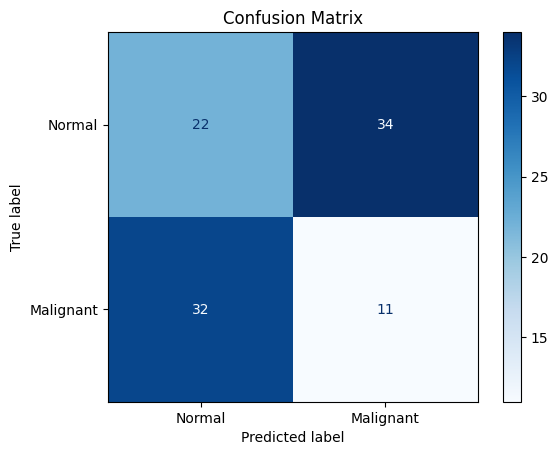

True Negatives (TN): 22 (22.22%)
False Positives (FP): 34 (34.34%)
False Negatives (FN): 32 (32.32%)
True Positives (TP): 11 (11.11%)


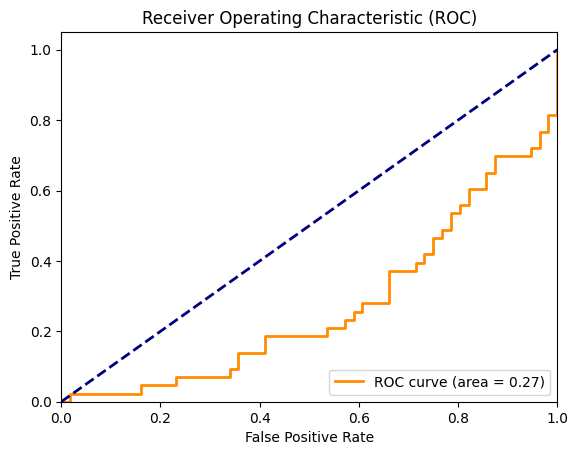

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

predictions = np.round(model.predict(test_generator)).astype(int).flatten()

true_classes = np.array(test_generator.classes)

cm = confusion_matrix(y_true=true_classes, y_pred=predictions)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Malignant']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.flatten()
metrics = {
    'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp,
    'TN%': (tn / cm.sum()) * 100,
    'FP%': (fp / cm.sum()) * 100,
    'FN%': (fn / cm.sum()) * 100,
    'TP%': (tp / cm.sum()) * 100
}

for key, value in metrics.items():
    print(f"{key}: {value:.2f}" if '%' in key else f"{key}: {int(value)}")

fpr, tpr, _ = roc_curve(y_true=true_classes, y_score=predictions)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()